In [7]:
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np


In [8]:
font_color = '#525252'
hfont = {'fontname':'Calibri'}

facecolor = '#eaeaf2'
color_red = '#fd625e'
color_blue = '#01b8aa'

def plot_graphs(df,country,save_fig_path):
    try:
        os.mkdir(save_fig_path)
    except:
        pass
    df=df.rename(columns = {'Normal':'ORIGINAL','Masked':'MASKED','Greyish':'GREYSCALE',
                           'Rgb0.3 Noise':'RGB-0.3','Rgb0.5 Noise':'RGB-0.5','Spread Noise':'SPREAD'})
    
    index = ['ORIGINAL','GREYSCALE','RGB-0.3','RGB-0.5','SPREAD','MASKED']
    
    df_res = df.copy()
    df_res = df_res[[0]+index]
    df_res.to_csv(save_fig_path.split('gender_wise')[0]+'accuracy_'+country+'.csv',index = False)
    
    column0 = []
    column1 = []
    for col in index:
        column0.append(df[col][1])
        column1.append(df[col][2])
    title0 = 'Male'
    title1 = 'Female'
    
    fig, axes = plt.subplots(figsize=(10,5), facecolor=facecolor, ncols=2, sharey=True)
    fig.tight_layout()

    axes[0].barh(index, column0, align='center', color=color_red)
    axes[0].set_title(title0, fontsize=18, pad=15, color=color_red, **hfont)
    axes[1].barh(index, column1, align='center', color=color_blue)
    axes[1].set_title(title1, fontsize=18, pad=15, color=color_blue, **hfont)
    
    # If you have positive numbers and want to invert the x-axis of the left plot
    axes[0].invert_xaxis() 

    # To show data from highest to lowest
    plt.gca().invert_yaxis()


    axes[0].set(yticks=index, yticklabels=index)
    axes[0].yaxis.tick_left()
    axes[0].tick_params(axis='y', colors='white') # tick color

    ticks = list(np.linspace(0,100,11,dtype = 'int'))
    axes[1].set_xticks(ticks)
    axes[1].set_xticklabels(ticks)

    axes[0].set_xticks(ticks)
    axes[0].set_xticklabels(ticks)

    for label in (axes[0].get_xticklabels() + axes[0].get_yticklabels()):
        label.set(fontsize=13, color=font_color, **hfont)
    for label in (axes[1].get_xticklabels() + axes[1].get_yticklabels()):
        label.set(fontsize=13, color=font_color, **hfont)
        

    
    for i, acc in enumerate(column0):
        axes[0].text(acc+15,i-0.05, acc, color='black', fontweight='bold',fontsize = 12)
    
    for i, acc in enumerate(column1):
        axes[1].text(acc+2,i-0.05, acc, color='black', fontweight='bold',fontsize = 12)

    plt.subplots_adjust(wspace=0, top=0.85, bottom=0.1, left=0.18, right=0.95)
    
    fig.supxlabel("Accuracy (%)")
    fig.supylabel("Image Type")
    fig.suptitle(country, fontsize=15)
    plt.savefig(save_fig_path+country+'.png',bbox_inches ="tight",dpi = 150)
    plt.show()

In [9]:
def plot_graph_overall(df,country,save_fig_path):
    try:
        os.mkdir(save_fig_path)
    except:
        pass
    
    df=df.rename(columns = {'Normal':'ORIGINAL','Masked':'MASKED','Greyish':'GREYSCALE',
                           'Rgb0.3 Noise':'RGB-0.3','Rgb0.5 Noise':'RGB-0.5','Spread Noise':'SPREAD'})
    
    index = ['ORIGINAL','GREYSCALE','RGB-0.3','RGB-0.5','SPREAD','MASKED']
    values = []
    for col in index:
        values.append(df[col][0])
    fig, ax = plt.subplots(figsize = (8, 4),facecolor=facecolor)
    ax.bar(index,values,color = "#0A4D68")
        
    for i,acc in enumerate(values):
        ax.text(i-0.2,acc+5,acc,color='black', fontweight='bold',fontsize = 12)
    
    plt.ylim(0,100)
    plt.xlabel("Image Type")
    plt.ylabel("Accuracy (%)")
    plt.title(country)
    plt.savefig(save_fig_path+country+"_overall"+'.jpg',dpi = 150)
    plt.show()

In [10]:

def doAnalysis(fileName,country,image_file_path,save_fig_path,status_csv_file,df_overall,df_tune,train_image_type):
    df = pd.read_csv(fileName)
    df_status = pd.read_csv(status_csv_file+".csv")
    #######################################################################################################
    ## All the players with JSON file don't have images (Due to YOLO or MASK some of the images did not generated)
    # to get the correct number of images which are tested in the API are needed
    df['valid normal'] = 0
    df['valid masked'] = 0
    image_folder_normal = image_file_path+country+"_resized/normal/"
    image_folder_masked = image_file_path+country+"_resized/masked/"
    
    # Process the normal images
    image_files = os.listdir(image_folder_normal)
    for name in image_files:
        name = name.split('.')[0]
        try:
            rowInd = df.index[df['name'] == name].tolist()[0]
            df.at[rowInd,'valid normal'] = 1
        except:
            pass
    
    #Process the masked images
    image_files = os.listdir(image_folder_masked)
    for name in image_files:
        name = name.split('.')[0].split('_N95')[0]
        try:
            rowInd = df.index[df['name'] == name].tolist()[0]
            df.at[rowInd,'valid masked'] = 1
        except:
            pass
        
    df.to_csv(fileName,index=False)
    
    ##################################################################################################
    columns = df.columns[2:-2]
    df_res = pd.DataFrame(['Overall','Male','Female'])

    for column in columns:
        print(column,train_image_type)
        ################# Consider only valid images for analysis ##############
        df_res[column.title()] = None
        image_type = 'normal'
        if column == 'Masked':
            image_type = 'masked'
        df_copy = df[['name','gender',column,'valid '+image_type]]
        df_copy=df_copy.rename(columns = {'valid '+image_type:'valid'})
        df_copy = df_copy[df_copy['valid'] == 1]
        ############ There are some greyscale and cartoonish images in the folder, we should  ############
        ##### not consider those images for our accuracy plot #####
        img_type = column.split()[0].lower()
        df_status['fileName'] = df_status['fileName'].apply(lambda x: x.split(".")[0])
        df_copy = df_copy.merge(df_status, left_on='name', right_on='fileName', how='inner')[['name','gender', column,'valid', 'status']]
        if img_type == "greyish":
            df_copy = df_copy[df_copy['status'].isin(['OK', 'GREY'])]
        else:
            df_copy = df_copy[df_copy['status'] == 'OK'] 
    
        ##########################################################################################################
#         print(df_copy)
#         print(len(df_copy))
        ###################### if train_image_type == column then drop those trained images ###########################
        if train_image_type == column:
            df_copy = df_copy.merge(df_tune,on='name', how='left', indicator=True)
            df_copy = df_copy[df_copy['_merge'] != 'both']
            df_copy = df_copy.drop('_merge', axis=1)
            df_copy = df_copy.reset_index()
            df_copy = df_copy.drop('index',axis = 1)
#         print(len(df_copy))
#     # Drop rows from df1 where column 'B' matches values in df2['B']
#     df_result = df.merge(df_tune, on='name', how='left', indicator=True)
#     df_result = df_result[df_result['_merge'] != 'both']
#     df_result = df_result.drop('_merge', axis=1)
#     df_result = df_result.reset_index()
#     df_result = df_result.drop('index',axis = 1)
#     print(len(df_result))
        ##########################################################################################################
#         column = column.capitalize()
        total = len(df_copy)
        df_male = df_copy.copy()
        df_male = df_male[df_male['gender'] == 'M']
        df_female = df_copy.copy()
        df_female = df_female[df_female['gender'] == 'F']
        
        total_male = len(df_male)
        total_female = len(df_female)
        
        total_correct_prediction = len(df_copy[df_copy['gender'] == df_copy[column]])
        correct_prediction_male = len(df_male[df_male['gender'] == df_male[column]])
        correct_prediction_female = len(df_female[df_female['gender'] == df_female[column]])
        
        overall_accuracy = (total_correct_prediction/total)*100
        male_accuracy = (correct_prediction_male/total_male)*100
        female_accuracy = (correct_prediction_female/total_female)*100
        
        df_res[column.title()][0] = round(overall_accuracy,2)
        df_res[column.title()][1] = round(male_accuracy,2)
        df_res[column.title()][2] = round(female_accuracy,2)
        
#     print(df_res)
#     print()
    try:
        os.mkdir(save_fig_path)
    except:
        pass
    df_res.to_csv(save_fig_path+'accuracy_'+country+'.csv',index = False)
    print("########### ",country," ###########")
    print(df_res)
    try:
        plot_graphs(df_res,country,save_fig_path+"gender_wise/")
        plot_graph_overall(df_res,country,save_fig_path+"overall/")
    except:
        print("Error in Plotting")
    return df_overall

In [11]:
def analysis(API_NAME,country,path,ground_path,trained_data):
    try:
        os.mkdir("./../Results in csv files/")
    except:
        pass
    try:
        os.mkdir("./../Results in csv files/"+API_NAME+"/")
    except:
        pass
    
    image_types = os.listdir(path+country+"/")
    
    #### Read Valid images files ####
    df = pd.read_csv(ground_path+"/"+country+".csv")
    df = df[['filename','gender']]
    df.rename(columns = {'filename':'name'}, inplace = True)
    
    print("############################## "+country+" ##############################")
#     print("Ground Truth Data reading DONE")
#     print(df)
    #====================================================================================
            
    for image_type in image_types:
        print(image_type)
        file_path = path+country+"/"+image_type ## name of the files where result is stored
        df[image_type.split('.txt')[0]] = None
        f = open(file_path,'r')
        lines = f.readlines()
        for line in lines:
            name = line.split('.')[0].split('_N95')[0]
#             print(name)
            try:
                female_prob = line.split(':')[1].split(',')[0].strip()
                male_prob = line.split(':')[-1].split('}')[0].strip()
#                 print(male_prob,female_prob)
                gender = 'M'
                if float(female_prob) > float(male_prob):
                    gender = 'F'
            except:
                continue
            try:
                rowInd = df.index[df['name'] == name].tolist()[0]
                df.at[rowInd,image_type.split('.txt')[0]] = gender
            except:
                continue
    print(len(df))
#     print(df)
#     ################# Drop those files which are used for fine-tuning ###########
# #     df_tune = pd.read_csv(trained_data)
#     lis_tune = []
#     male_female = os.listdir(trained_data)
#     for mf in male_female:
#         train_path = trained_data+"/"+mf
#         imgs = os.listdir(train_path)
#         for img in imgs:
#             lis_tune.append(img.split('.')[0])
# #     print(lis_tune)
#     df_tune = pd.DataFrame(lis_tune,columns = ['name'])
# #     print(df_tune)
# #     return
#     # Drop rows from df1 where column 'B' matches values in df2['B']
#     df_result = df.merge(df_tune, on='name', how='left', indicator=True)
#     df_result = df_result[df_result['_merge'] != 'both']
#     df_result = df_result.drop('_merge', axis=1)
#     df_result = df_result.reset_index()
#     df_result = df_result.drop('index',axis = 1)
#     print(len(df_result))
    
    out_path = "./../Results in csv files/"+API_NAME+"/"+country+'.csv'
    df.to_csv(out_path,index=False)

In [12]:
num_img_category = 10
img_type = "" ## trained images type

train_img_type_dict = {
    "":"normal",
    "greyish":"Greyish",
    "rgb":'RGB0.3 Noise',
    "spread":'Spread Noise',
    "masked":"masked"
}

train_image_type = train_img_type_dict[img_type]

if img_type == "":
    API_NAME = 'result_'+str(num_img_category) #Enter API name
    trained_data = "data_"+str(num_img_category)+"/train"
else:
    API_NAME = 'result_'+img_type+"_"+str(num_img_category) #Enter API name
    trained_data = "data_"+img_type+"_"+str(num_img_category)+"/train"
    
# trained_data = "details_"+str(num_img_category)+".csv"
print(API_NAME)
print(trained_data)

ground_path = "./../image_details/"

lis_tune = []
male_female = os.listdir(trained_data)
for mf in male_female:
    train_path = trained_data+"/"+mf
    imgs = os.listdir(train_path)
    for img in imgs:
        lis_tune.append(img.split('.')[0].split('_N95')[0])
#     print(lis_tune)
df_tune = pd.DataFrame(lis_tune,columns = ['name'])
# print(df_tune)
path = API_NAME+'/'
countries = os.listdir(path)
# countries = ['Australia']
for country in countries:
    analysis(API_NAME,country,path,ground_path,trained_data)

result_10
data_10/train
############################## Australia ##############################
Greyish.txt
masked.txt
normal.txt
RGB0.3 Noise.txt
RGB0.5 Noise.txt
Spread Noise.txt
941
############################## Bangladesh ##############################
Greyish.txt
masked.txt
normal.txt
RGB0.3 Noise.txt
RGB0.5 Noise.txt
Spread Noise.txt
367
############################## England ##############################
Greyish.txt
masked.txt
normal.txt
RGB0.3 Noise.txt
RGB0.5 Noise.txt
Spread Noise.txt
1418
############################## India ##############################
Greyish.txt
masked.txt
normal.txt
RGB0.3 Noise.txt
RGB0.5 Noise.txt
Spread Noise.txt
2254
############################## New Zealand ##############################
Greyish.txt
masked.txt
normal.txt
RGB0.3 Noise.txt
RGB0.5 Noise.txt
Spread Noise.txt
597
############################## Pakistan ##############################
Greyish.txt
masked.txt
normal.txt
RGB0.3 Noise.txt
RGB0.5 Noise.txt
Spread Noise.txt
557
############

Greyish normal
masked normal
normal normal
RGB0.3 Noise normal
RGB0.5 Noise normal
Spread Noise normal
###########  Australia  ###########
         0 Greyish Masked Normal Rgb0.3 Noise Rgb0.5 Noise Spread Noise
0  Overall   52.77  15.03  56.52        24.12         7.27        44.85
1     Male   53.23  15.92  58.08        29.43         9.01        54.35
2   Female   50.83  11.32  49.66         1.89          0.0         5.03


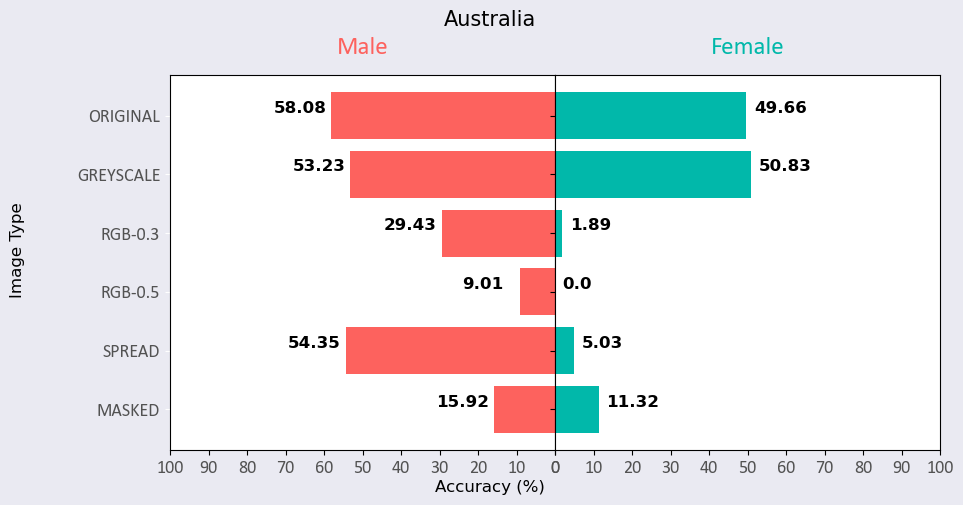

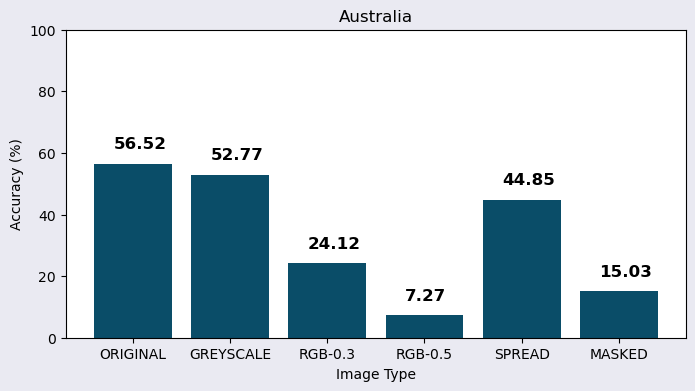

Greyish normal
masked normal
normal normal
RGB0.3 Noise normal
RGB0.5 Noise normal
Spread Noise normal
###########  Bangladesh  ###########
         0 Greyish Masked Normal Rgb0.3 Noise Rgb0.5 Noise Spread Noise
0  Overall   55.04  16.62  53.31        20.71          4.9        46.59
1     Male   53.66  16.46  52.83        22.87         5.49        51.52
2   Female   66.67  17.95  58.62         2.56          0.0         5.13


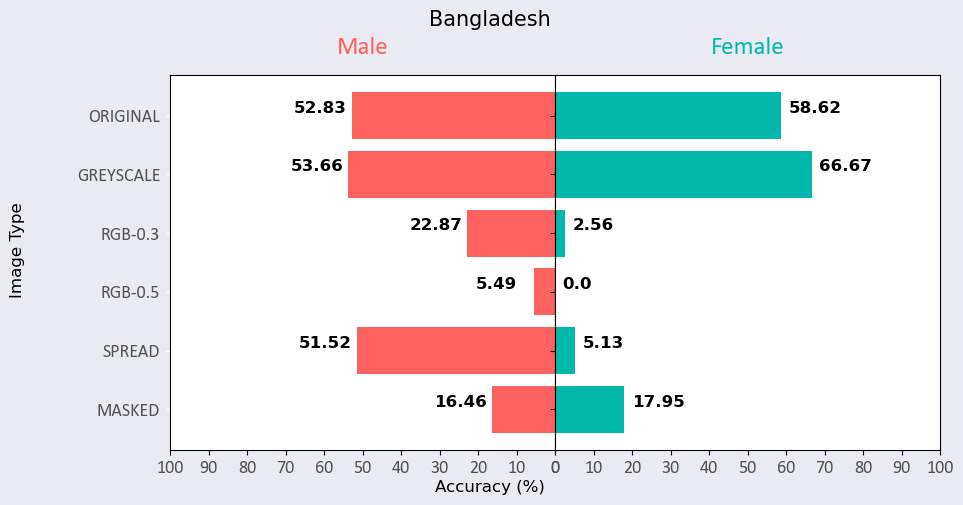

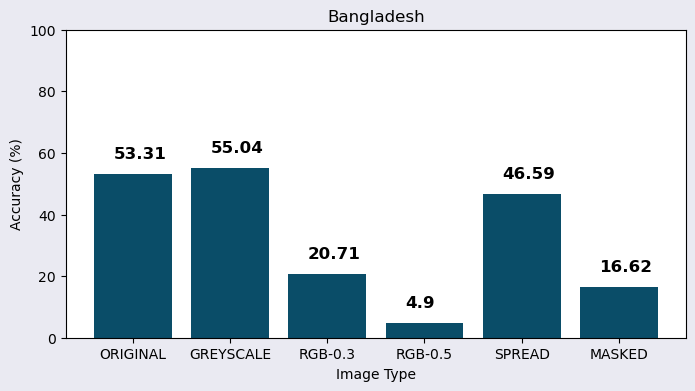

Greyish normal
masked normal
normal normal
RGB0.3 Noise normal
RGB0.5 Noise normal
Spread Noise normal
###########  England  ###########
         0 Greyish Masked Normal Rgb0.3 Noise Rgb0.5 Noise Spread Noise
0  Overall   35.98   6.61  42.06        12.75         3.21        31.82
1     Male   34.01   5.49  39.91        13.73         3.59        35.06
2   Female   54.89  16.07  61.76         4.46          0.0         4.46


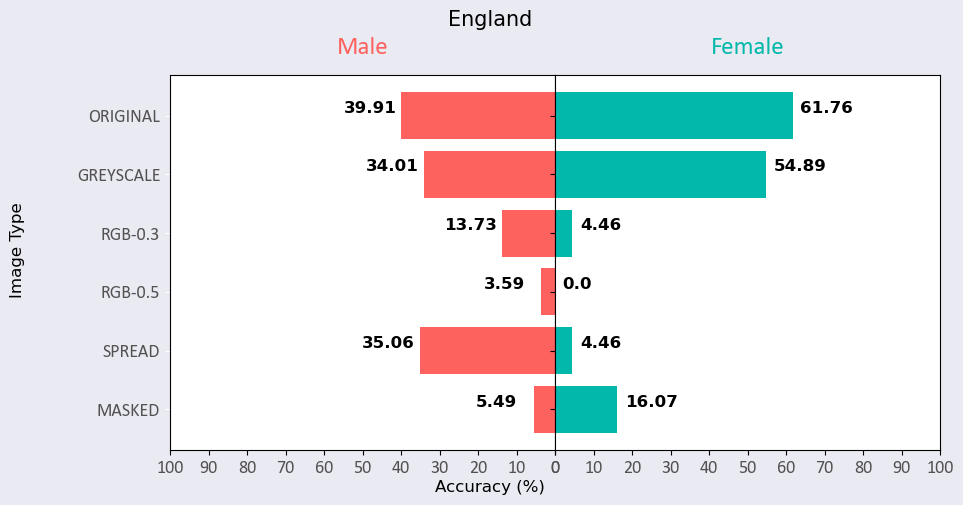

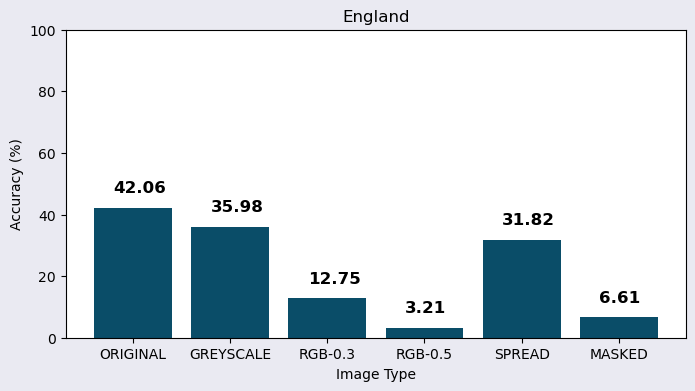

Greyish normal
masked normal
normal normal
RGB0.3 Noise normal
RGB0.5 Noise normal
Spread Noise normal
###########  India  ###########
         0 Greyish Masked Normal Rgb0.3 Noise Rgb0.5 Noise Spread Noise
0  Overall   48.71  21.18  49.04        24.66         6.55        42.27
1     Male   48.94  21.21  49.54        26.96         7.17        45.83
2   Female   46.28  20.86   43.5         0.53          0.0         4.81


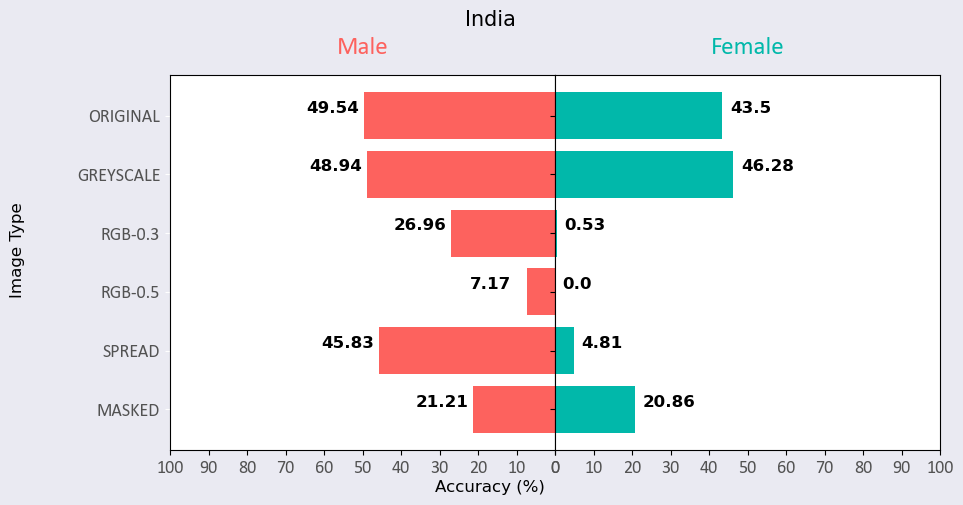

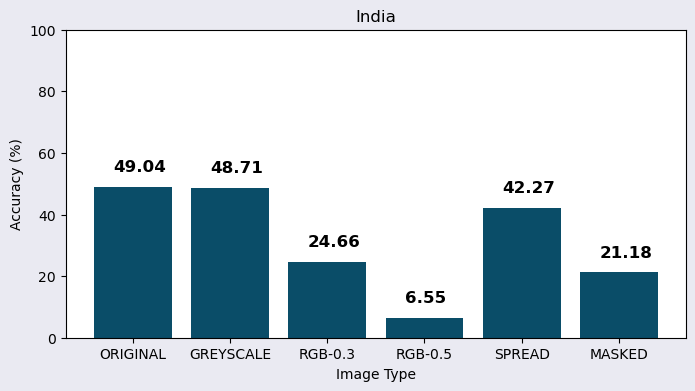

Greyish normal
masked normal
normal normal
RGB0.3 Noise normal
RGB0.5 Noise normal
Spread Noise normal
###########  New Zealand  ###########
         0 Greyish Masked Normal Rgb0.3 Noise Rgb0.5 Noise Spread Noise
0  Overall   43.38  10.11  45.51        12.64         1.99        31.95
1     Male    46.3   9.94  49.68        21.12         3.42        49.69
2   Female   38.79  10.34  39.64         0.86          0.0         7.33


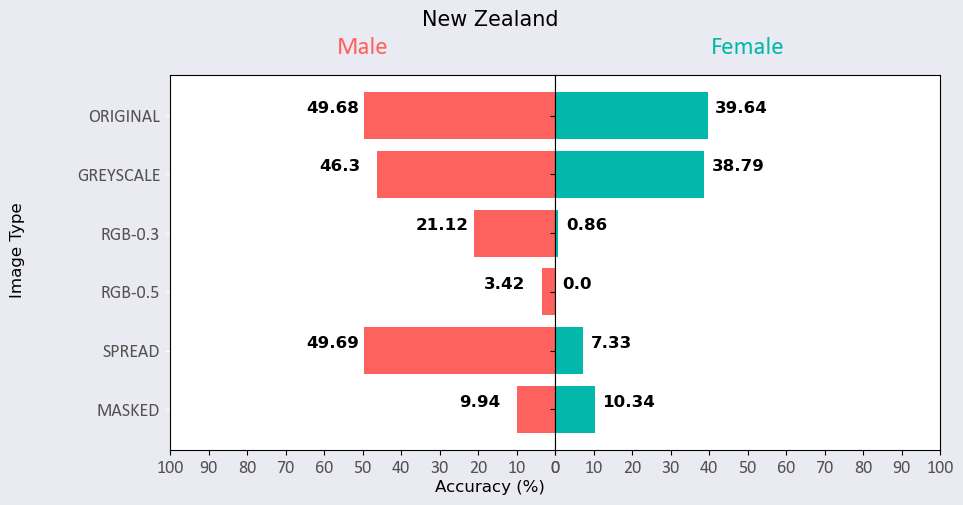

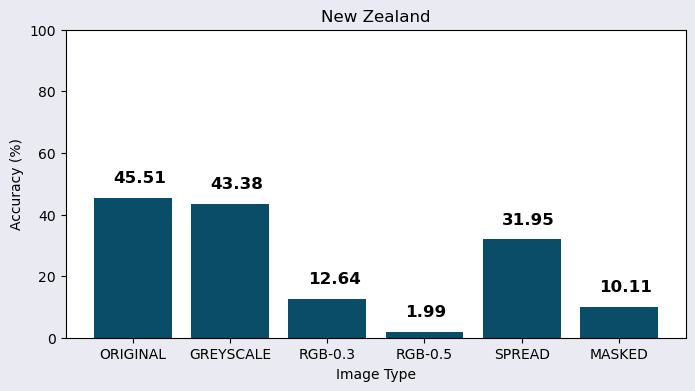

Greyish normal
masked normal
normal normal
RGB0.3 Noise normal
RGB0.5 Noise normal
Spread Noise normal
###########  Pakistan  ###########
         0 Greyish Masked Normal Rgb0.3 Noise Rgb0.5 Noise Spread Noise
0  Overall   57.81  28.41  57.49        31.09         9.79        47.02
1     Male   57.32  27.15  57.18        36.43        11.54        54.75
2   Female   60.76  35.44  59.42         1.27          0.0          3.8


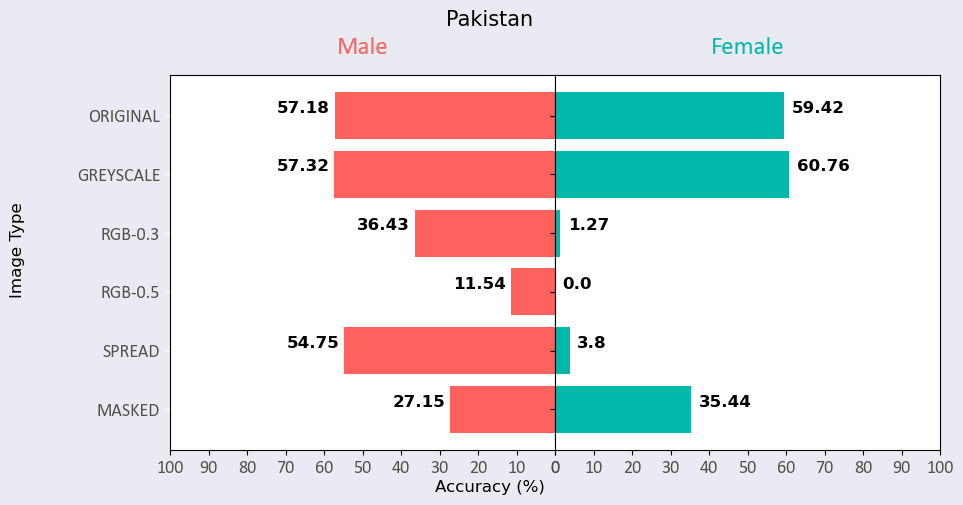

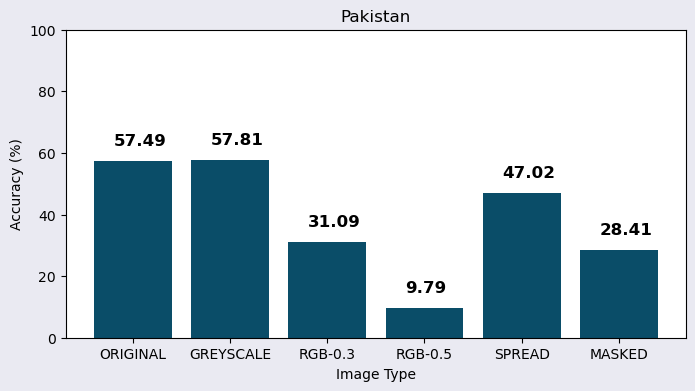

Greyish normal
masked normal
normal normal
RGB0.3 Noise normal
RGB0.5 Noise normal
Spread Noise normal
###########  South Africa  ###########
         0 Greyish Masked Normal Rgb0.3 Noise Rgb0.5 Noise Spread Noise
0  Overall   51.94  15.11  54.66        22.07         5.57        47.51
1     Male   51.87  14.64  55.53         25.0         6.31        53.83
2   Female   52.54  18.64  46.94          0.0          0.0          0.0


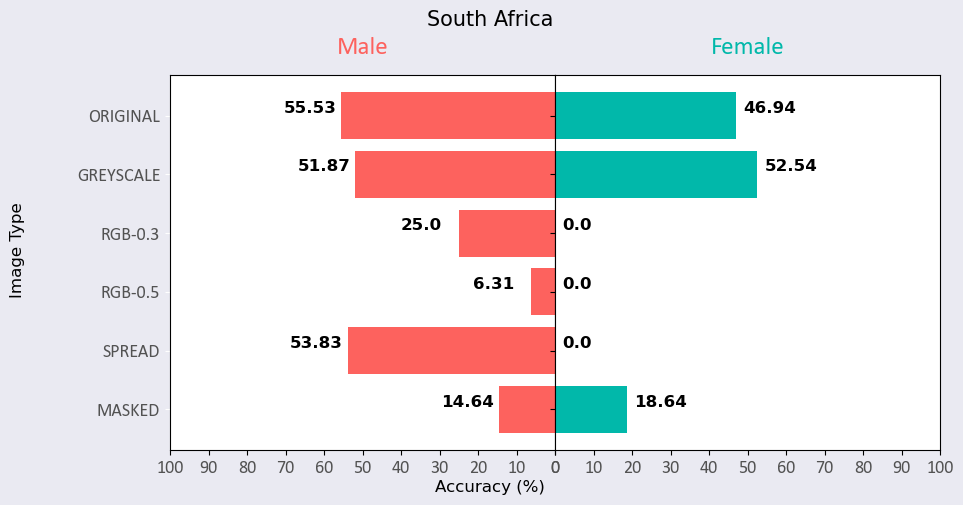

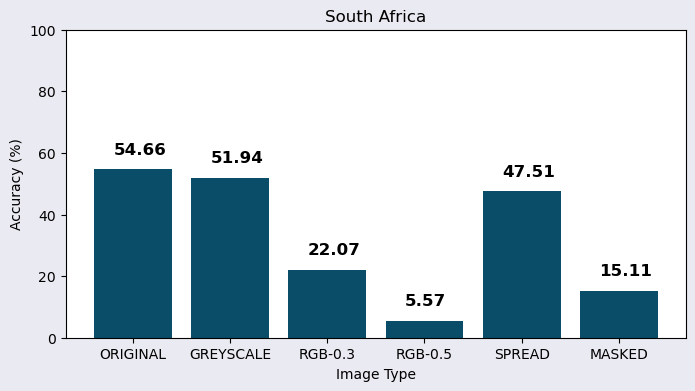

Greyish normal
masked normal
normal normal
RGB0.3 Noise normal
RGB0.5 Noise normal
Spread Noise normal
###########  West Indies  ###########
         0 Greyish Masked Normal Rgb0.3 Noise Rgb0.5 Noise Spread Noise
0  Overall   42.53   5.36  42.46         9.21         1.84        35.85
1     Male   41.95   5.25  42.83        10.32         2.06        39.59
2   Female   47.69   6.25  38.89          0.0          0.0         4.69


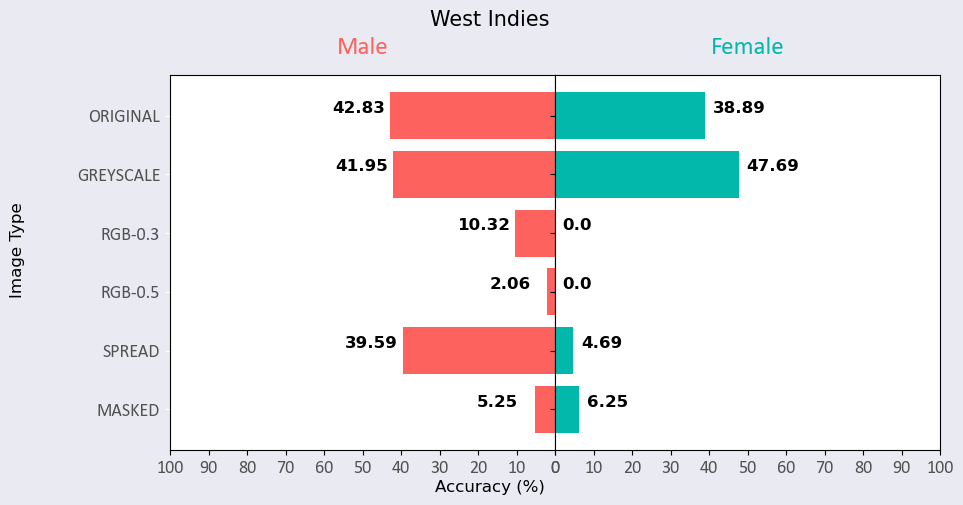

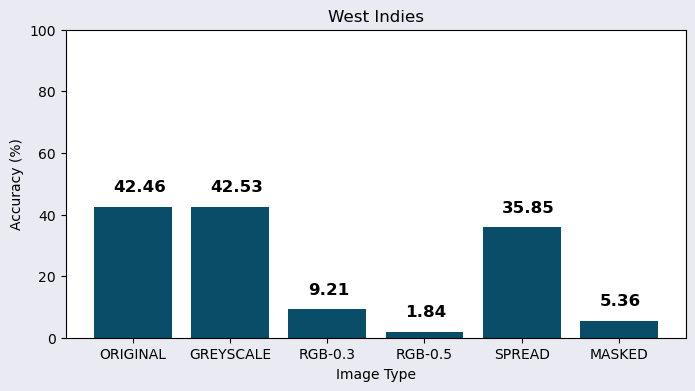

In [13]:
image_file_path = "./../All Face Images with And Without Mask (N95)/"
status_csv_file = "./../correction/status_csv_files/"

try:
    os.mkdir("./../plots/")
    os.mkdir("./../plots/"+API_NAME)
except:
    pass
try:
    os.mkdir("./../plots/"+API_NAME+'/overall')
except:
    pass
try:
    os.mkdir("./../plots/"+API_NAME+'/gender_wise')
except:
    pass
save_fig_path = "./../plots/"+API_NAME+"/"

countries = os.listdir(path)
# countries = ['Australia']

df_overall = pd.DataFrame()
for country in countries:
    filePath = "./../Results in csv files/"+API_NAME+"/"+country+'.csv'
    df_overall = doAnalysis(filePath,country,image_file_path,save_fig_path,status_csv_file+country,df_overall,df_tune,train_image_type)
#     df_overall = df_overall.append(df_temp)


## Getting the Overall accuracy of entire dataset

In [8]:
def overall_accuracy(df,df_tune,train_image_type):
    img_types = df.columns[2:-4]
#     print(df.columns)
#     print(img_types)
    for img_type in img_types:
        print("Image Type : "+img_type)
        is_masked = img_type.split()[-1].lower() == 'masked'
        print(is_masked)
        df_total = df.copy()
        if is_masked:
            df_total = df[df['valid masked'] == 1]
        df_copy = df_total[['name','gender',img_type,'status']]
        if img_type.lower() != 'greyish':
            df_copy = df_copy[df_copy['status'] == 'OK']
            df_copy = df_copy.reset_index()
            df_copy = df_copy.drop('index',axis = 1)
        print(len(df_copy))
        ###################### if train_image_type == column then drop those trained images ###########################
#         print(train_image_type,img_type)
        if train_image_type == img_type:
            df_copy = df_copy.merge(df_tune,on='name', how='left', indicator=True)
            df_copy = df_copy[df_copy['_merge'] != 'both']
            df_copy = df_copy.drop('_merge', axis=1)
            df_copy = df_copy.reset_index()
            df_copy = df_copy.drop('index',axis = 1)
        print(len(df_copy))
        
        total = len(df_copy)
        df_male = df_copy[df_copy['gender'] == 'M']
        df_female = df_copy[df_copy['gender'] == 'F']

        total_male = len(df_male)
        total_female = len(df_female)

        predicted_male = len(df_male[df_male[img_type] == 'M'])
        predicted_female = len(df_female[df_female[img_type] == 'F'])

        total_correct_prediction = len(df_copy[df_copy['gender'] == df_copy[img_type]])
#         print("Total : ",total)
#         print("Total correct prediction : ",total_correct_prediction)
        
        
        
        print("Overall Male accuracy : %0.2f"%((predicted_male/total_male)*100))
        print("Overall Female accuracy : %0.2f"%((predicted_female/total_female)*100))
        print("Overall Accuracy : %0.2f"%((total_correct_prediction/total)*100))
        print()

In [9]:
## remove black&white images and cartoon images
def process_result(df,status_csv_file,country):
    df_status = pd.read_csv(status_csv_file+'/'+country)
    df_status['fileName'] = df_status['fileName'].apply(lambda x: x.split(".")[0])
    df_status = df_status[(df_status['status'] == 'OK') | (df_status['status'] == 'GREY')]
    df_status = df_status.reset_index()
    df_status = df_status.drop('index',axis = 1)
    df = df.merge(df_status, left_on='name', right_on='fileName', how='inner')
    df = df.drop('fileName',axis = 1)
    return df
#     print(df)
    

In [10]:
res_csv_path = "./../Results in csv files/"+API_NAME
countries = os.listdir(res_csv_path)
df_overall = pd.DataFrame()
for country in countries:
    df = pd.read_csv(res_csv_path+"/"+country)
    df = process_result(df,status_csv_file,country) ## removed black&white images and cartoon images
    df_overall = df_overall.append(df)
#     break
df_overall = df_overall.reset_index()
df_overall = df_overall.drop('index',axis = 1)
# print(df_overall)
overall_accuracy(df_overall,df_tune,train_image_type)

Image Type : Greyish
False
7314
7314
Overall Male accuracy : 46.40
Overall Female accuracy : 47.54
Overall Accuracy : 46.55

Image Type : masked
True
6425
6425
Overall Male accuracy : 16.30
Overall Female accuracy : 16.28
Overall Accuracy : 16.30

Image Type : normal
False
6579
6499
Overall Male accuracy : 49.09
Overall Female accuracy : 47.47
Overall Accuracy : 48.87

Image Type : RGB0.3 Noise
False
6579
6579
Overall Male accuracy : 23.44
Overall Female accuracy : 5.16
Overall Accuracy : 20.85

Image Type : RGB0.5 Noise
False
6579
6579
Overall Male accuracy : 6.27
Overall Female accuracy : 0.00
Overall Accuracy : 5.38

Image Type : Spread Noise
False
6579
6579
Overall Male accuracy : 46.28
Overall Female accuracy : 6.34
Overall Accuracy : 40.63



## Just for simply copying the result into google sheet

In [11]:
save_fig_path = "./../plots/"+API_NAME+"/"
files = os.listdir(save_fig_path)

df_all = pd.DataFrame()
df_all['country'] = None
for file in files: # countries
    pref = file.split("_")[0]
    if pref != 'accuracy':
        continue
    df = pd.read_csv(save_fig_path+'/'+file)
#     print(df)
#     break
    country = file.split("_")[-1].split(".")[0]
#     print(country)
    img_types = df.columns[1:]
    if len(df_all.columns) == 1:
        all_columns = []
        for img_type in img_types:
            all_columns.append('male-'+img_type)
            all_columns.append('female-'+img_type)
            all_columns.append('overall-'+img_type)
    #     print(all_columns)
        for col in all_columns:
            df_all[col] = None
    data = [country]
    for img_type in img_types:
        data.append(df[img_type][1])
        data.append(df[img_type][2])
        data.append(df[img_type][0])
    print(data)
    df_all.loc[len(df_all.index)] = data

df_all.to_csv(save_fig_path+"all_accuracy.csv",index = False)

['Australia', 57.49, 55.19, 57.06, 52.83, 52.49, 52.77, 29.43, 4.4, 24.61, 9.01, 0.0, 7.27, 54.2, 6.29, 44.97, 15.92, 10.69, 14.91]
['Bangladesh', 52.32, 44.12, 51.54, 53.66, 53.85, 53.68, 22.87, 7.69, 21.25, 5.49, 0.0, 4.9, 51.22, 7.69, 46.59, 17.07, 20.51, 17.44]
['England', 39.17, 61.68, 41.47, 33.46, 56.39, 35.63, 13.73, 13.39, 13.69, 3.59, 0.0, 3.21, 34.95, 8.93, 32.2, 5.91, 18.75, 7.27]
['India', 49.41, 40.66, 48.67, 48.94, 39.36, 48.14, 26.96, 2.14, 24.8, 7.17, 0.0, 6.55, 45.88, 2.67, 42.13, 21.87, 19.25, 21.64]
['New Zealand', 49.21, 38.33, 44.67, 45.75, 38.36, 42.88, 21.12, 5.17, 14.44, 3.42, 0.0, 1.99, 49.69, 9.48, 32.85, 9.94, 11.21, 10.47]
['Pakistan', 57.21, 48.65, 55.97, 57.74, 50.63, 56.73, 36.2, 3.8, 31.29, 11.54, 0.0, 9.79, 54.75, 2.53, 46.83, 28.51, 32.91, 29.17]
['South Africa', 53.99, 59.26, 54.56, 50.62, 61.02, 51.76, 24.77, 6.78, 22.66, 6.31, 0.0, 5.57, 53.83, 5.08, 48.11, 14.41, 18.64, 14.91]
['West Indies', 42.23, 47.46, 42.76, 40.92, 52.31, 42.06, 10.32, 0.0, 9

In [12]:
df_all

,country,male-ORIGINAL,female-ORIGINAL,overall-ORIGINAL,male-GREYSCALE,female-GREYSCALE,overall-GREYSCALE,male-RGB-0.3,female-RGB-0.3,overall-RGB-0.3,male-RGB-0.5,female-RGB-0.5,overall-RGB-0.5,male-SPREAD,female-SPREAD,overall-SPREAD,male-MASKED,female-MASKED,overall-MASKED
0,Australia,57.49,55.19,57.06,52.83,52.49,52.77,29.43,4.40,24.61,9.01,0.0,7.27,54.20,6.29,44.97,15.92,10.69,14.91
1,Bangladesh,52.32,44.12,51.54,53.66,53.85,53.68,22.87,7.69,21.25,5.49,0.0,4.90,51.22,7.69,46.59,17.07,20.51,17.44
2,England,39.17,61.68,41.47,33.46,56.39,35.63,13.73,13.39,13.69,3.59,0.0,3.21,34.95,8.93,32.20,5.91,18.75,7.27
3,India,49.41,40.66,48.67,48.94,39.36,48.14,26.96,2.14,24.80,7.17,0.0,6.55,45.88,2.67,42.13,21.87,19.25,21.64
4,New Zealand,49.21,38.33,44.67,45.75,38.36,42.88,21.12,5.17,14.44,3.42,0.0,1.99,49.69,9.48,32.85,9.94,11.21,10.47
5,Pakistan,57.21,48.65,55.97,57.74,50.63,56.73,36.20,3.80,31.29,11.54,0.0,9.79,54.75,2.53,46.83,28.51,32.91,29.17
6,South Africa,53.99,59.26,54.56,50.62,61.02,51.76,24.77,6.78,22.66,6.31,0.0,5.57,53.83,5.08,48.11,14.41,18.64,14.91
7,West Indies,42.23,47.46,42.76,40.92,52.31,42.06,10.32,0.00,9.21,2.06,0.0,1.84,39.59,6.25,36.01,5.25,6.25,5.36


In [21]:
len(df_all)

8